# webscraping

# Team season average data

## Acquire data from basketball-reference.com

In [169]:
import pandas as pd
import requests, bs4, re
from bs4 import BeautifulSoup as bs
import numpy as np

### Get links of 20 seasons

In [170]:
seasonlinks=[]
for i in range(2002,2023):
    link='https://www.basketball-reference.com/leagues/NBA_'+str(i)+'.html'
    seasonlinks.append(link)
seasonlinks

['https://www.basketball-reference.com/leagues/NBA_2002.html',
 'https://www.basketball-reference.com/leagues/NBA_2003.html',
 'https://www.basketball-reference.com/leagues/NBA_2004.html',
 'https://www.basketball-reference.com/leagues/NBA_2005.html',
 'https://www.basketball-reference.com/leagues/NBA_2006.html',
 'https://www.basketball-reference.com/leagues/NBA_2007.html',
 'https://www.basketball-reference.com/leagues/NBA_2008.html',
 'https://www.basketball-reference.com/leagues/NBA_2009.html',
 'https://www.basketball-reference.com/leagues/NBA_2010.html',
 'https://www.basketball-reference.com/leagues/NBA_2011.html',
 'https://www.basketball-reference.com/leagues/NBA_2012.html',
 'https://www.basketball-reference.com/leagues/NBA_2013.html',
 'https://www.basketball-reference.com/leagues/NBA_2014.html',
 'https://www.basketball-reference.com/leagues/NBA_2015.html',
 'https://www.basketball-reference.com/leagues/NBA_2016.html',
 'https://www.basketball-reference.com/leagues/NBA_2017

In [568]:
len(seasonlinks)

21

### Acquiring data of 20 seasons

Team data + Opponent data

In [171]:
#function for tabularizing data of one page:
def tabu(soup, year):
    
    #PER GAME
    pergametable=soup.find('table', id='per_game-team')
    pergamecolumns=[] #get columns
    for i in pergametable.find('tr').find_all('th')[1:]:
        pergamecolumns.append(i['data-stat'])
    pergametrs=pergametable.find_all('tr')
    pergamerows=[]
    for tr in pergametrs[1:]:
        tds=tr.find_all('td')
        row=[td.text.replace('*','') for td in tds]
        pergamerows.append(row)
    pergamedf=pd.DataFrame(pergamerows, columns=pergamecolumns)
    
    #OPP PER GAME
    opppergametable=soup.find('table', id='per_game-opponent')
    opppergamecolumns=[] #get columns
    for i in opppergametable.find('tr').find_all('th')[1:]:
        opppergamecolumns.append(i['data-stat'])
    opppergametrs=opppergametable.find_all('tr')
    opppergamerows=[]
    for tr in opppergametrs[1:]:
        tds=tr.find_all('td')
        row=[td.text.replace('*','') for td in tds]
        opppergamerows.append(row)
    opppergamedf=pd.DataFrame(opppergamerows, columns=opppergamecolumns)    
    
    #ADVANCED
    advancedtable=soup.find('table', id='advanced-team')
    advancedcolumns=[] #get columns
    for i in advancedtable.find_all('tr')[1].find_all('th')[1:]:
        if str(i['data-stat']) == 'team':
            advancedcolumns.append(str(i['data-stat']))
        else:
            advancedcolumns.append(str(i['data-stat'])+'_adv')
    advancedtrs=advancedtable.find_all('tr')
    advancedrows=[]
    for tr in advancedtrs[2:]:
        tds=tr.find_all('td')
        row=[td.text.replace('*','').replace('+','').replace(',','') for td in tds]
        advancedrows.append(row)
    advanceddf=pd.DataFrame(advancedrows, columns=advancedcolumns)
    
    #SHOOTING
    shootingtable=soup.find('table', id='shooting-team')
    shootingcolumns=[]
    for i in shootingtable.find_all('tr')[1].find_all('th')[1:]:
        shootingcolumns.append(i['data-stat'])
    shootingtrs=shootingtable.find_all('tr')
    shootingrows=[]
    for tr in shootingtrs[2:]:
        tds=tr.find_all('td')
        row=[td.text.replace('*','') for td in tds]
        shootingrows.append(row)
    shootingdf=pd.DataFrame(shootingrows, columns=shootingcolumns)
    
    #OPP SHOOTING
    oppshootingtable=soup.find('table', id='shooting-opponent')
    oppshootingcolumns=[]
    for i in oppshootingtable.find_all('tr')[1].find_all('th')[1:]:
        oppshootingcolumns.append(i['data-stat'])
    oppshootingtrs=oppshootingtable.find_all('tr')
    oppshootingrows=[]
    for tr in oppshootingtrs[2:]:
        tds=tr.find_all('td')
        row=[td.text.replace('*','') for td in tds]
        oppshootingrows.append(row)
    oppshootingdf=pd.DataFrame(oppshootingrows, columns=oppshootingcolumns)    
    
    
    #CONCAT THREE
    pergamedf.set_index('team',inplace=True)
    opppergamedf.set_index('team',inplace=True)
    advanceddf.set_index('team',inplace=True)
    shootingdf.set_index('team',inplace=True)
    oppshootingdf.set_index('team',inplace=True)
    
    out_df = pd.concat([pergamedf,opppergamedf,advanceddf,shootingdf,oppshootingdf],axis=1,sort=False).reset_index()
    
    out_df['Year'] = year
    
    return out_df

In [249]:
#iterate through 21 years
#tabularized data saved in a dict by year
datadict={}
for url in seasonlinks:
    year=url[-9:-5]
    response = requests.get(url)
    status = response.status_code
    if status == 200:
      page = response.text
      soup = bs(page)
    else:
      print(f"Oops! Received status code {status}")
    
    outdf=tabu(soup, year)
    datadict[year]=outdf

In [250]:
len(datadict)

21

In [330]:
#concat all dfs in the dict
all_df=pd.concat(datadict.values(), ignore_index=True)

In [176]:
all_df.to_csv('bballref_df.csv')

## Acquire data from NBA.com

### Get season links

In [46]:
cats=['drives','catch-shoot','passing','pullup','speed-distance','elbow-touch','tracking-post-ups','paint-touch']
nbacomlinks={}
for cat in cats:
    nbacomlinks[cat]=[]
    for i in range(13,22):
        link='https://www.nba.com/stats/teams/'+cat+'/?Season=20'+str(i)+'-'+str(i+1)+'&SeasonType=Regular%20Season'
        nbacomlinks[cat].append(link)

In [47]:
nbacomlinks

{'drives': ['https://www.nba.com/stats/teams/drives/?Season=2013-14&SeasonType=Regular%20Season',
  'https://www.nba.com/stats/teams/drives/?Season=2014-15&SeasonType=Regular%20Season',
  'https://www.nba.com/stats/teams/drives/?Season=2015-16&SeasonType=Regular%20Season',
  'https://www.nba.com/stats/teams/drives/?Season=2016-17&SeasonType=Regular%20Season',
  'https://www.nba.com/stats/teams/drives/?Season=2017-18&SeasonType=Regular%20Season',
  'https://www.nba.com/stats/teams/drives/?Season=2018-19&SeasonType=Regular%20Season',
  'https://www.nba.com/stats/teams/drives/?Season=2019-20&SeasonType=Regular%20Season',
  'https://www.nba.com/stats/teams/drives/?Season=2020-21&SeasonType=Regular%20Season',
  'https://www.nba.com/stats/teams/drives/?Season=2021-22&SeasonType=Regular%20Season'],
 'catch-shoot': ['https://www.nba.com/stats/teams/catch-shoot/?Season=2013-14&SeasonType=Regular%20Season',
  'https://www.nba.com/stats/teams/catch-shoot/?Season=2014-15&SeasonType=Regular%20Seaso

### Acquire data (NBA.com is dynamic, need selenium)

In [147]:
#d = webdriver.Chrome() #https://stackoverflow.com/a/64775957
#function for tabularizing data of one page:
def nbatabu(d, url, subcolumns, columnnames, year):
    
    d.get(url)
    sleep(5)
    s = bs(d.page_source, 'html.parser').find('table', {'class':'table'})

    rows=[[i.text.strip() for i in b.find_all('td')] for b in s.find_all('tr')]
    rows = [i for i in rows if len(i) > 1]
    rowsdf=pd.DataFrame(rows)
    rowsdf=rowsdf.iloc[:,subcolumns]
    rowsdf.columns=columnnames
    rowsdf['Year'] = year
    
    return rowsdf

In [100]:
from time import sleep

In [144]:
#drives df
#iterate through 9 years
#tabularized data saved in a dict by year

subcolumns=[0,5]
columnnames=['team','drives']
drivesdict={}
for url in nbacomlinks['drives']:
    d = webdriver.Chrome()
    year=int(url[-35:-31])+1
    print(url)
    print(year)
    outdf=nbatabu(d=d, url=url, subcolumns=subcolumns, columnnames=columnnames, year=year)
    drivesdict[year]=outdf
    d.close()
    #sleep(3)

https://www.nba.com/stats/teams/drives/?Season=2013-14&SeasonType=Regular%20Season
2014
https://www.nba.com/stats/teams/drives/?Season=2014-15&SeasonType=Regular%20Season
2015
https://www.nba.com/stats/teams/drives/?Season=2015-16&SeasonType=Regular%20Season
2016
https://www.nba.com/stats/teams/drives/?Season=2016-17&SeasonType=Regular%20Season
2017
https://www.nba.com/stats/teams/drives/?Season=2017-18&SeasonType=Regular%20Season
2018
https://www.nba.com/stats/teams/drives/?Season=2018-19&SeasonType=Regular%20Season
2019
https://www.nba.com/stats/teams/drives/?Season=2019-20&SeasonType=Regular%20Season
2020
https://www.nba.com/stats/teams/drives/?Season=2020-21&SeasonType=Regular%20Season
2021
https://www.nba.com/stats/teams/drives/?Season=2021-22&SeasonType=Regular%20Season
2022


In [150]:
#catch-shoot df
#iterate through 9 years
#tabularized data saved in a dict by year

subcolumns=[0,5]
columnnames=['team','catchshootattempt']
catchshootdict={}
for url in nbacomlinks['catch-shoot']:
    d = webdriver.Chrome()
    year=int(url[-35:-31])+1
    print(url)
    print(year)
    outdf=nbatabu(d=d, url=url, subcolumns=subcolumns, columnnames=columnnames, year=year)
    catchshootdict[year]=outdf
    d.close()
    #sleep(3)

https://www.nba.com/stats/teams/catch-shoot/?Season=2013-14&SeasonType=Regular%20Season
2014
https://www.nba.com/stats/teams/catch-shoot/?Season=2014-15&SeasonType=Regular%20Season
2015
https://www.nba.com/stats/teams/catch-shoot/?Season=2015-16&SeasonType=Regular%20Season
2016
https://www.nba.com/stats/teams/catch-shoot/?Season=2016-17&SeasonType=Regular%20Season
2017
https://www.nba.com/stats/teams/catch-shoot/?Season=2017-18&SeasonType=Regular%20Season
2018
https://www.nba.com/stats/teams/catch-shoot/?Season=2018-19&SeasonType=Regular%20Season
2019
https://www.nba.com/stats/teams/catch-shoot/?Season=2019-20&SeasonType=Regular%20Season
2020
https://www.nba.com/stats/teams/catch-shoot/?Season=2020-21&SeasonType=Regular%20Season
2021
https://www.nba.com/stats/teams/catch-shoot/?Season=2021-22&SeasonType=Regular%20Season
2022


In [151]:
#passing df
#iterate through 9 years
#tabularized data saved in a dict by year

subcolumns=[0,5,9]
columnnames=['team','passes','potentialasst']
passingdict={}
for url in nbacomlinks['passing']:
    d = webdriver.Chrome()
    year=int(url[-35:-31])+1
    print(url)
    print(year)
    outdf=nbatabu(d=d, url=url, subcolumns=subcolumns, columnnames=columnnames, year=year)
    passingdict[year]=outdf
    d.close()
    #sleep(3)

https://www.nba.com/stats/teams/passing/?Season=2013-14&SeasonType=Regular%20Season
2014
https://www.nba.com/stats/teams/passing/?Season=2014-15&SeasonType=Regular%20Season
2015
https://www.nba.com/stats/teams/passing/?Season=2015-16&SeasonType=Regular%20Season
2016
https://www.nba.com/stats/teams/passing/?Season=2016-17&SeasonType=Regular%20Season
2017
https://www.nba.com/stats/teams/passing/?Season=2017-18&SeasonType=Regular%20Season
2018
https://www.nba.com/stats/teams/passing/?Season=2018-19&SeasonType=Regular%20Season
2019
https://www.nba.com/stats/teams/passing/?Season=2019-20&SeasonType=Regular%20Season
2020
https://www.nba.com/stats/teams/passing/?Season=2020-21&SeasonType=Regular%20Season
2021
https://www.nba.com/stats/teams/passing/?Season=2021-22&SeasonType=Regular%20Season
2022


In [152]:
#pullup df
#iterate through 9 years
#tabularized data saved in a dict by year

subcolumns=[0,7]
columnnames=['team','pullupfgattempt']
pullupdict={}
for url in nbacomlinks['pullup']:
    d = webdriver.Chrome()
    year=int(url[-35:-31])+1
    print(url)
    print(year)
    outdf=nbatabu(d=d, url=url, subcolumns=subcolumns, columnnames=columnnames, year=year)
    pullupdict[year]=outdf
    d.close()
    #sleep(3)

https://www.nba.com/stats/teams/pullup/?Season=2013-14&SeasonType=Regular%20Season
2014
https://www.nba.com/stats/teams/pullup/?Season=2014-15&SeasonType=Regular%20Season
2015
https://www.nba.com/stats/teams/pullup/?Season=2015-16&SeasonType=Regular%20Season
2016
https://www.nba.com/stats/teams/pullup/?Season=2016-17&SeasonType=Regular%20Season
2017
https://www.nba.com/stats/teams/pullup/?Season=2017-18&SeasonType=Regular%20Season
2018
https://www.nba.com/stats/teams/pullup/?Season=2018-19&SeasonType=Regular%20Season
2019
https://www.nba.com/stats/teams/pullup/?Season=2019-20&SeasonType=Regular%20Season
2020
https://www.nba.com/stats/teams/pullup/?Season=2020-21&SeasonType=Regular%20Season
2021
https://www.nba.com/stats/teams/pullup/?Season=2021-22&SeasonType=Regular%20Season
2022


In [153]:
#speed-distance df
#iterate through 9 years
#tabularized data saved in a dict by year

subcolumns=[0,6,9]
columnnames=['team','distance','speed']
speeddistancedict={}
for url in nbacomlinks['speed-distance']:
    d = webdriver.Chrome()
    year=int(url[-35:-31])+1
    print(url)
    print(year)
    outdf=nbatabu(d=d, url=url, subcolumns=subcolumns, columnnames=columnnames, year=year)
    speeddistancedict[year]=outdf
    d.close()
    #sleep(3)

https://www.nba.com/stats/teams/speed-distance/?Season=2013-14&SeasonType=Regular%20Season
2014
https://www.nba.com/stats/teams/speed-distance/?Season=2014-15&SeasonType=Regular%20Season
2015
https://www.nba.com/stats/teams/speed-distance/?Season=2015-16&SeasonType=Regular%20Season
2016
https://www.nba.com/stats/teams/speed-distance/?Season=2016-17&SeasonType=Regular%20Season
2017
https://www.nba.com/stats/teams/speed-distance/?Season=2017-18&SeasonType=Regular%20Season
2018
https://www.nba.com/stats/teams/speed-distance/?Season=2018-19&SeasonType=Regular%20Season
2019
https://www.nba.com/stats/teams/speed-distance/?Season=2019-20&SeasonType=Regular%20Season
2020
https://www.nba.com/stats/teams/speed-distance/?Season=2020-21&SeasonType=Regular%20Season
2021
https://www.nba.com/stats/teams/speed-distance/?Season=2021-22&SeasonType=Regular%20Season
2022


In [154]:
#elbow-touch df
#iterate through 9 years
#tabularized data saved in a dict by year

subcolumns=[0,5,6]
columnnames=['team','touches','elbowtouches']
elbowtouchdict={}
for url in nbacomlinks['elbow-touch']:
    d = webdriver.Chrome()
    year=int(url[-35:-31])+1
    print(url)
    print(year)
    outdf=nbatabu(d=d, url=url, subcolumns=subcolumns, columnnames=columnnames, year=year)
    elbowtouchdict[year]=outdf
    d.close()
    #sleep(3)

https://www.nba.com/stats/teams/elbow-touch/?Season=2013-14&SeasonType=Regular%20Season
2014
https://www.nba.com/stats/teams/elbow-touch/?Season=2014-15&SeasonType=Regular%20Season
2015
https://www.nba.com/stats/teams/elbow-touch/?Season=2015-16&SeasonType=Regular%20Season
2016
https://www.nba.com/stats/teams/elbow-touch/?Season=2016-17&SeasonType=Regular%20Season
2017
https://www.nba.com/stats/teams/elbow-touch/?Season=2017-18&SeasonType=Regular%20Season
2018
https://www.nba.com/stats/teams/elbow-touch/?Season=2018-19&SeasonType=Regular%20Season
2019
https://www.nba.com/stats/teams/elbow-touch/?Season=2019-20&SeasonType=Regular%20Season
2020
https://www.nba.com/stats/teams/elbow-touch/?Season=2020-21&SeasonType=Regular%20Season
2021
https://www.nba.com/stats/teams/elbow-touch/?Season=2021-22&SeasonType=Regular%20Season
2022


In [155]:
#tracking-post-ups df
#iterate through 9 years
#tabularized data saved in a dict by year

subcolumns=[0,6]
columnnames=['team','postups']
postupdict={}
for url in nbacomlinks['tracking-post-ups']:
    d = webdriver.Chrome()
    year=int(url[-35:-31])+1
    print(url)
    print(year)
    outdf=nbatabu(d=d, url=url, subcolumns=subcolumns, columnnames=columnnames, year=year)
    postupdict[year]=outdf
    d.close()
    #sleep(3)

https://www.nba.com/stats/teams/tracking-post-ups/?Season=2013-14&SeasonType=Regular%20Season
2014
https://www.nba.com/stats/teams/tracking-post-ups/?Season=2014-15&SeasonType=Regular%20Season
2015
https://www.nba.com/stats/teams/tracking-post-ups/?Season=2015-16&SeasonType=Regular%20Season
2016
https://www.nba.com/stats/teams/tracking-post-ups/?Season=2016-17&SeasonType=Regular%20Season
2017
https://www.nba.com/stats/teams/tracking-post-ups/?Season=2017-18&SeasonType=Regular%20Season
2018
https://www.nba.com/stats/teams/tracking-post-ups/?Season=2018-19&SeasonType=Regular%20Season
2019
https://www.nba.com/stats/teams/tracking-post-ups/?Season=2019-20&SeasonType=Regular%20Season
2020
https://www.nba.com/stats/teams/tracking-post-ups/?Season=2020-21&SeasonType=Regular%20Season
2021
https://www.nba.com/stats/teams/tracking-post-ups/?Season=2021-22&SeasonType=Regular%20Season
2022


In [156]:
#paint-touch df
#iterate through 9 years
#tabularized data saved in a dict by year

subcolumns=[0,6]
columnnames=['team','painttouches']
painttouchdict={}
for url in nbacomlinks['paint-touch']:
    d = webdriver.Chrome()
    year=int(url[-35:-31])+1
    print(url)
    print(year)
    outdf=nbatabu(d=d, url=url, subcolumns=subcolumns, columnnames=columnnames, year=year)
    painttouchdict[year]=outdf
    d.close()
    #sleep(3)

https://www.nba.com/stats/teams/paint-touch/?Season=2013-14&SeasonType=Regular%20Season
2014
https://www.nba.com/stats/teams/paint-touch/?Season=2014-15&SeasonType=Regular%20Season
2015
https://www.nba.com/stats/teams/paint-touch/?Season=2015-16&SeasonType=Regular%20Season
2016
https://www.nba.com/stats/teams/paint-touch/?Season=2016-17&SeasonType=Regular%20Season
2017
https://www.nba.com/stats/teams/paint-touch/?Season=2017-18&SeasonType=Regular%20Season
2018
https://www.nba.com/stats/teams/paint-touch/?Season=2018-19&SeasonType=Regular%20Season
2019
https://www.nba.com/stats/teams/paint-touch/?Season=2019-20&SeasonType=Regular%20Season
2020
https://www.nba.com/stats/teams/paint-touch/?Season=2020-21&SeasonType=Regular%20Season
2021
https://www.nba.com/stats/teams/paint-touch/?Season=2021-22&SeasonType=Regular%20Season
2022


In [159]:
drivesdf=pd.concat(drivesdict.values(), ignore_index=True)
catchshootdf=pd.concat(catchshootdict.values(), ignore_index=True)
passingdf=pd.concat(passingdict.values(), ignore_index=True)
pullupdf=pd.concat(pullupdict.values(), ignore_index=True)
speeddistancedf=pd.concat(speeddistancedict.values(), ignore_index=True)
elbowtouchdf=pd.concat(elbowtouchdict.values(), ignore_index=True)
postupdf=pd.concat(postupdict.values(), ignore_index=True)
painttouchdf=pd.concat(painttouchdict.values(), ignore_index=True)

In [161]:
df_list = [drivesdf, catchshootdf, passingdf, pullupdf, speeddistancedf, elbowtouchdf, postupdf, painttouchdf]

In [163]:
from functools import reduce

In [308]:
nba_df=reduce(lambda left,right: pd.merge(left,right,on=['team','Year'], how='outer'), df_list)

In [167]:
nba_df.to_csv('nba_df.csv')

In [309]:
nba_df=nba_df.astype(str)

In [310]:
all_df=all_df.astype(str)

In [311]:
nba_df['team'] = nba_df['team'].str.replace('LA Clippers','Los Angeles Clippers')

In [440]:
#merge bball ref with nba.com data
combined_df=pd.merge(all_df,nba_df,on=['team','Year'], how='outer')

In [433]:
all_df

team   g     mp    fg   fga fg_pct   fg3  fg3a fg3_pct  \
0          Dallas Mavericks  82  242.4  39.0  84.5   .462   7.6  20.1    .378   
1          Sacramento Kings  82  240.9  39.8  85.4   .467   5.2  14.1    .367   
2        Los Angeles Lakers  82  241.2  38.4  83.4   .461   6.2  17.5    .354   
3             Orlando Magic  82  241.8  37.6  84.1   .448   7.6  20.2    .373   
4    Minnesota Timberwolves  82  241.5  38.7  84.0   .461   4.8  12.8    .378   
..                      ...  ..    ...   ...   ...    ...   ...   ...     ...   
643         New York Knicks  59  241.7  37.5  86.5   .434  13.1  37.1    .352   
644           Orlando Magic  60  240.4  38.0  87.7   .433  11.9  36.2    .330   
645         Detroit Pistons  58  240.9  37.3  88.6   .421  11.1  34.6    .320   
646   Oklahoma City Thunder  58  241.3  37.4  89.4   .418  11.8  37.5    .313   
647          League Average  59  241.3  40.2  88.2   .456  12.3  35.3    .349   

      fg2  ... DUMMY opp_pct_fga_dunk opp_fg_dunk DUMMY opp_pct_fga_layup  \
0    31.5  ...                   .058         364                    .261   
1    34.6  ...                   .044         283                    .181   
2    32.2  ...                   .048         304                    .190   
3    30.1  ...                   .053         333                    .225   
4    33.9  ...                   .054         335                    .214   
..    ...  ...   ...              ...         ...   ...               ...   
643  24.5  ...                   .055         257                    .264   
644  26.0  ...                   .054         262                    .254   
645  26.2  ...                   .063         280                    .280   
646  25.6  ...                   .054         230                    .268   
647  27.9  ...                   .056         258                    .265   

    opp_fg_layup DUMMY opp_pct_fg3a_corner opp_fg3_pct_corner  Year  
0            944                      .258               .335  2002  
1            744                      .251               .380  2002  
2            728                      .194               .369  2002  
3            856                      .278               .406  2002  
4            746                      .267               .408  2002  
..           ...   ...                 ...                ...   ...  
643          730                      .238               .356  2022  
644          722                      .233               .386  2022  
645          786                      .256               .420  2022  
646          765                      .249               .392  2022  
647          761                      .234               .379  2022  

[648 rows x 140 columns]

In [434]:
combined_df

team   g     mp    fg   fga fg_pct   fg3  fg3a fg3_pct  \
0          Dallas Mavericks  82  242.4  39.0  84.5   .462   7.6  20.1    .378   
1          Sacramento Kings  82  240.9  39.8  85.4   .467   5.2  14.1    .367   
2        Los Angeles Lakers  82  241.2  38.4  83.4   .461   6.2  17.5    .354   
3             Orlando Magic  82  241.8  37.6  84.1   .448   7.6  20.2    .373   
4    Minnesota Timberwolves  82  241.5  38.7  84.0   .461   4.8  12.8    .378   
..                      ...  ..    ...   ...   ...    ...   ...   ...     ...   
643         New York Knicks  59  241.7  37.5  86.5   .434  13.1  37.1    .352   
644           Orlando Magic  60  240.4  38.0  87.7   .433  11.9  36.2    .330   
645         Detroit Pistons  58  240.9  37.3  88.6   .421  11.1  34.6    .320   
646   Oklahoma City Thunder  58  241.3  37.4  89.4   .418  11.8  37.5    .313   
647          League Average  59  241.3  40.2  88.2   .456  12.3  35.3    .349   

      fg2  ... catchshootattempt passes potentialasst pullupfgattempt  \
0    31.5  ...               NaN    NaN           NaN             NaN   
1    34.6  ...               NaN    NaN           NaN             NaN   
2    32.2  ...               NaN    NaN           NaN             NaN   
3    30.1  ...               NaN    NaN           NaN             NaN   
4    33.9  ...               NaN    NaN           NaN             NaN   
..    ...  ...               ...    ...           ...             ...   
643  24.5  ...              24.2  277.9          41.2            27.7   
644  26.0  ...              28.8  283.3          46.4            19.6   
645  26.2  ...              28.6  305.2          46.6            19.9   
646  25.6  ...              29.8  297.6          45.6            20.1   
647  27.9  ...               NaN    NaN           NaN             NaN   

    distance speed touches elbowtouches postups painttouches  
0        NaN   NaN     NaN          NaN     NaN          NaN  
1        NaN   NaN     NaN          NaN     NaN          NaN  
2        NaN   NaN     NaN          NaN     NaN          NaN  
3        NaN   NaN     NaN          NaN     NaN          NaN  
4        NaN   NaN     NaN          NaN     NaN          NaN  
..       ...   ...     ...          ...     ...          ...  
643    17.88  4.16   398.5          7.3     5.8         20.0  
644    18.16  4.24   404.6          9.2     4.7         18.5  
645    18.23  4.24   428.5          9.6     6.3         21.8  
646    18.24  4.25   419.6          8.1     1.3         20.8  
647      NaN   NaN     NaN          NaN     NaN          NaN  

[648 rows x 151 columns]

In [441]:
#clean up useless features
combined_df = combined_df[~(combined_df.team == 'League Average')]
combined_df.drop(['g','DUMMY','arena_name_adv','DUMMY_adv','mp'], axis=1, inplace=True)
combined_df = combined_df.replace('', 0)
combined_df.loc[:,combined_df.columns != 'team']=combined_df.loc[:,combined_df.columns != 'team'].astype(np.float64)

In [443]:
combined_df.dtypes

team            object
fg              object
fga             object
fg_pct          object
fg3             object
                 ...  
speed           object
touches         object
elbowtouches    object
postups         object
painttouches    object
Length: 126, dtype: object

In [444]:
#rmove duplicated columns
combined_df = combined_df.loc[:,~combined_df.columns.duplicated()]

In [445]:
combined_df.shape

(627, 124)

In [446]:
#get team/opponent differentials as new columns
for column in combined_df.columns:
    if column.startswith('opp_'):
        team_column=column[4:]
        diff_column='diff_'+team_column
        print(diff_column)
        combined_df[diff_column]=combined_df[team_column]-combined_df[column]

diff_fg
diff_fga
diff_fg_pct
diff_fg3
diff_fg3a
diff_fg3_pct
diff_fg2
diff_fg2a
diff_fg2_pct
diff_ft
diff_fta
diff_ft_pct
diff_orb
diff_drb
diff_trb
diff_ast
diff_stl
diff_blk
diff_tov
diff_pf
diff_pts
diff_efg_pct_adv
diff_tov_pct_adv
diff_ft_rate_adv
diff_avg_dist
diff_pct_fga_fg2a
diff_pct_fga_00_03
diff_pct_fga_03_10
diff_pct_fga_10_16
diff_pct_fga_16_xx
diff_pct_fga_fg3a
diff_fg_pct_fg2a
diff_fg_pct_00_03
diff_fg_pct_03_10
diff_fg_pct_10_16
diff_fg_pct_16_xx
diff_fg_pct_fg3a
diff_pct_ast_fg2
diff_pct_ast_fg3
diff_pct_fga_dunk
diff_fg_dunk
diff_pct_fga_layup
diff_fg_layup
diff_pct_fg3a_corner
diff_fg3_pct_corner


In [338]:
combined_df.columns.tolist()

['fg',
 'fga',
 'fg_pct',
 'fg3',
 'fg3a',
 'fg3_pct',
 'fg2',
 'fg2a',
 'fg2_pct',
 'ft',
 'fta',
 'ft_pct',
 'orb',
 'drb',
 'trb',
 'ast',
 'stl',
 'blk',
 'tov',
 'pf',
 'pts',
 'opp_fg',
 'opp_fga',
 'opp_fg_pct',
 'opp_fg3',
 'opp_fg3a',
 'opp_fg3_pct',
 'opp_fg2',
 'opp_fg2a',
 'opp_fg2_pct',
 'opp_ft',
 'opp_fta',
 'opp_ft_pct',
 'opp_orb',
 'opp_drb',
 'opp_trb',
 'opp_ast',
 'opp_stl',
 'opp_blk',
 'opp_tov',
 'opp_pf',
 'opp_pts',
 'age_adv',
 'wins_adv',
 'losses_adv',
 'wins_pyth_adv',
 'losses_pyth_adv',
 'mov_adv',
 'sos_adv',
 'srs_adv',
 'off_rtg_adv',
 'def_rtg_adv',
 'net_rtg_adv',
 'pace_adv',
 'fta_per_fga_pct_adv',
 'fg3a_per_fga_pct_adv',
 'ts_pct_adv',
 'efg_pct_adv',
 'tov_pct_adv',
 'orb_pct_adv',
 'ft_rate_adv',
 'opp_efg_pct_adv',
 'opp_tov_pct_adv',
 'drb_pct_adv',
 'opp_ft_rate_adv',
 'attendance_adv',
 'attendance_per_g_adv',
 'avg_dist',
 'pct_fga_fg2a',
 'pct_fga_00_03',
 'pct_fga_03_10',
 'pct_fga_10_16',
 'pct_fga_16_xx',
 'pct_fga_fg3a',
 'fg_pct_fg2

In [341]:
#subset for bball ref only data
#subset_feature_list=['net_rtg_adv','pace_adv','diff_fga','diff_orb','diff_drb','diff_fta','diff_stl','diff_blk',
                     'diff_tov_pct_adv',
                     'diff_pct_fga_00_03','diff_pct_fga_03_10','diff_pct_fga_10_16','diff_pct_fga_16_xx',
                     'diff_pct_ast_fg2','diff_pct_ast_fg3','diff_pct_fga_fg3a','diff_pct_fg3a_corner',
                     'diff_fg_layup','diff_fg_dunk']

In [447]:
#subset for nba.com + bball ref data
subset_feature_list=['net_rtg_adv','pace_adv','diff_fga','diff_orb','diff_drb','diff_fta','diff_stl','diff_blk',
                     'diff_tov_pct_adv',
                     'diff_pct_fga_00_03','diff_pct_fga_03_10','diff_pct_fga_10_16','diff_pct_fga_16_xx',
                     'diff_pct_ast_fg2','diff_pct_ast_fg3','diff_pct_fga_fg3a','diff_pct_fg3a_corner',
                     'diff_fg_layup','diff_fg_dunk','drives',
 'catchshootattempt',
 'passes',
 'potentialasst',
 'pullupfgattempt',
 'distance',
 'speed',
 'touches',
 'elbowtouches',
 'postups',
 'painttouches']


In [370]:
combined_df_subset = combined_df[subset_feature_list]

In [213]:
import seaborn as sns

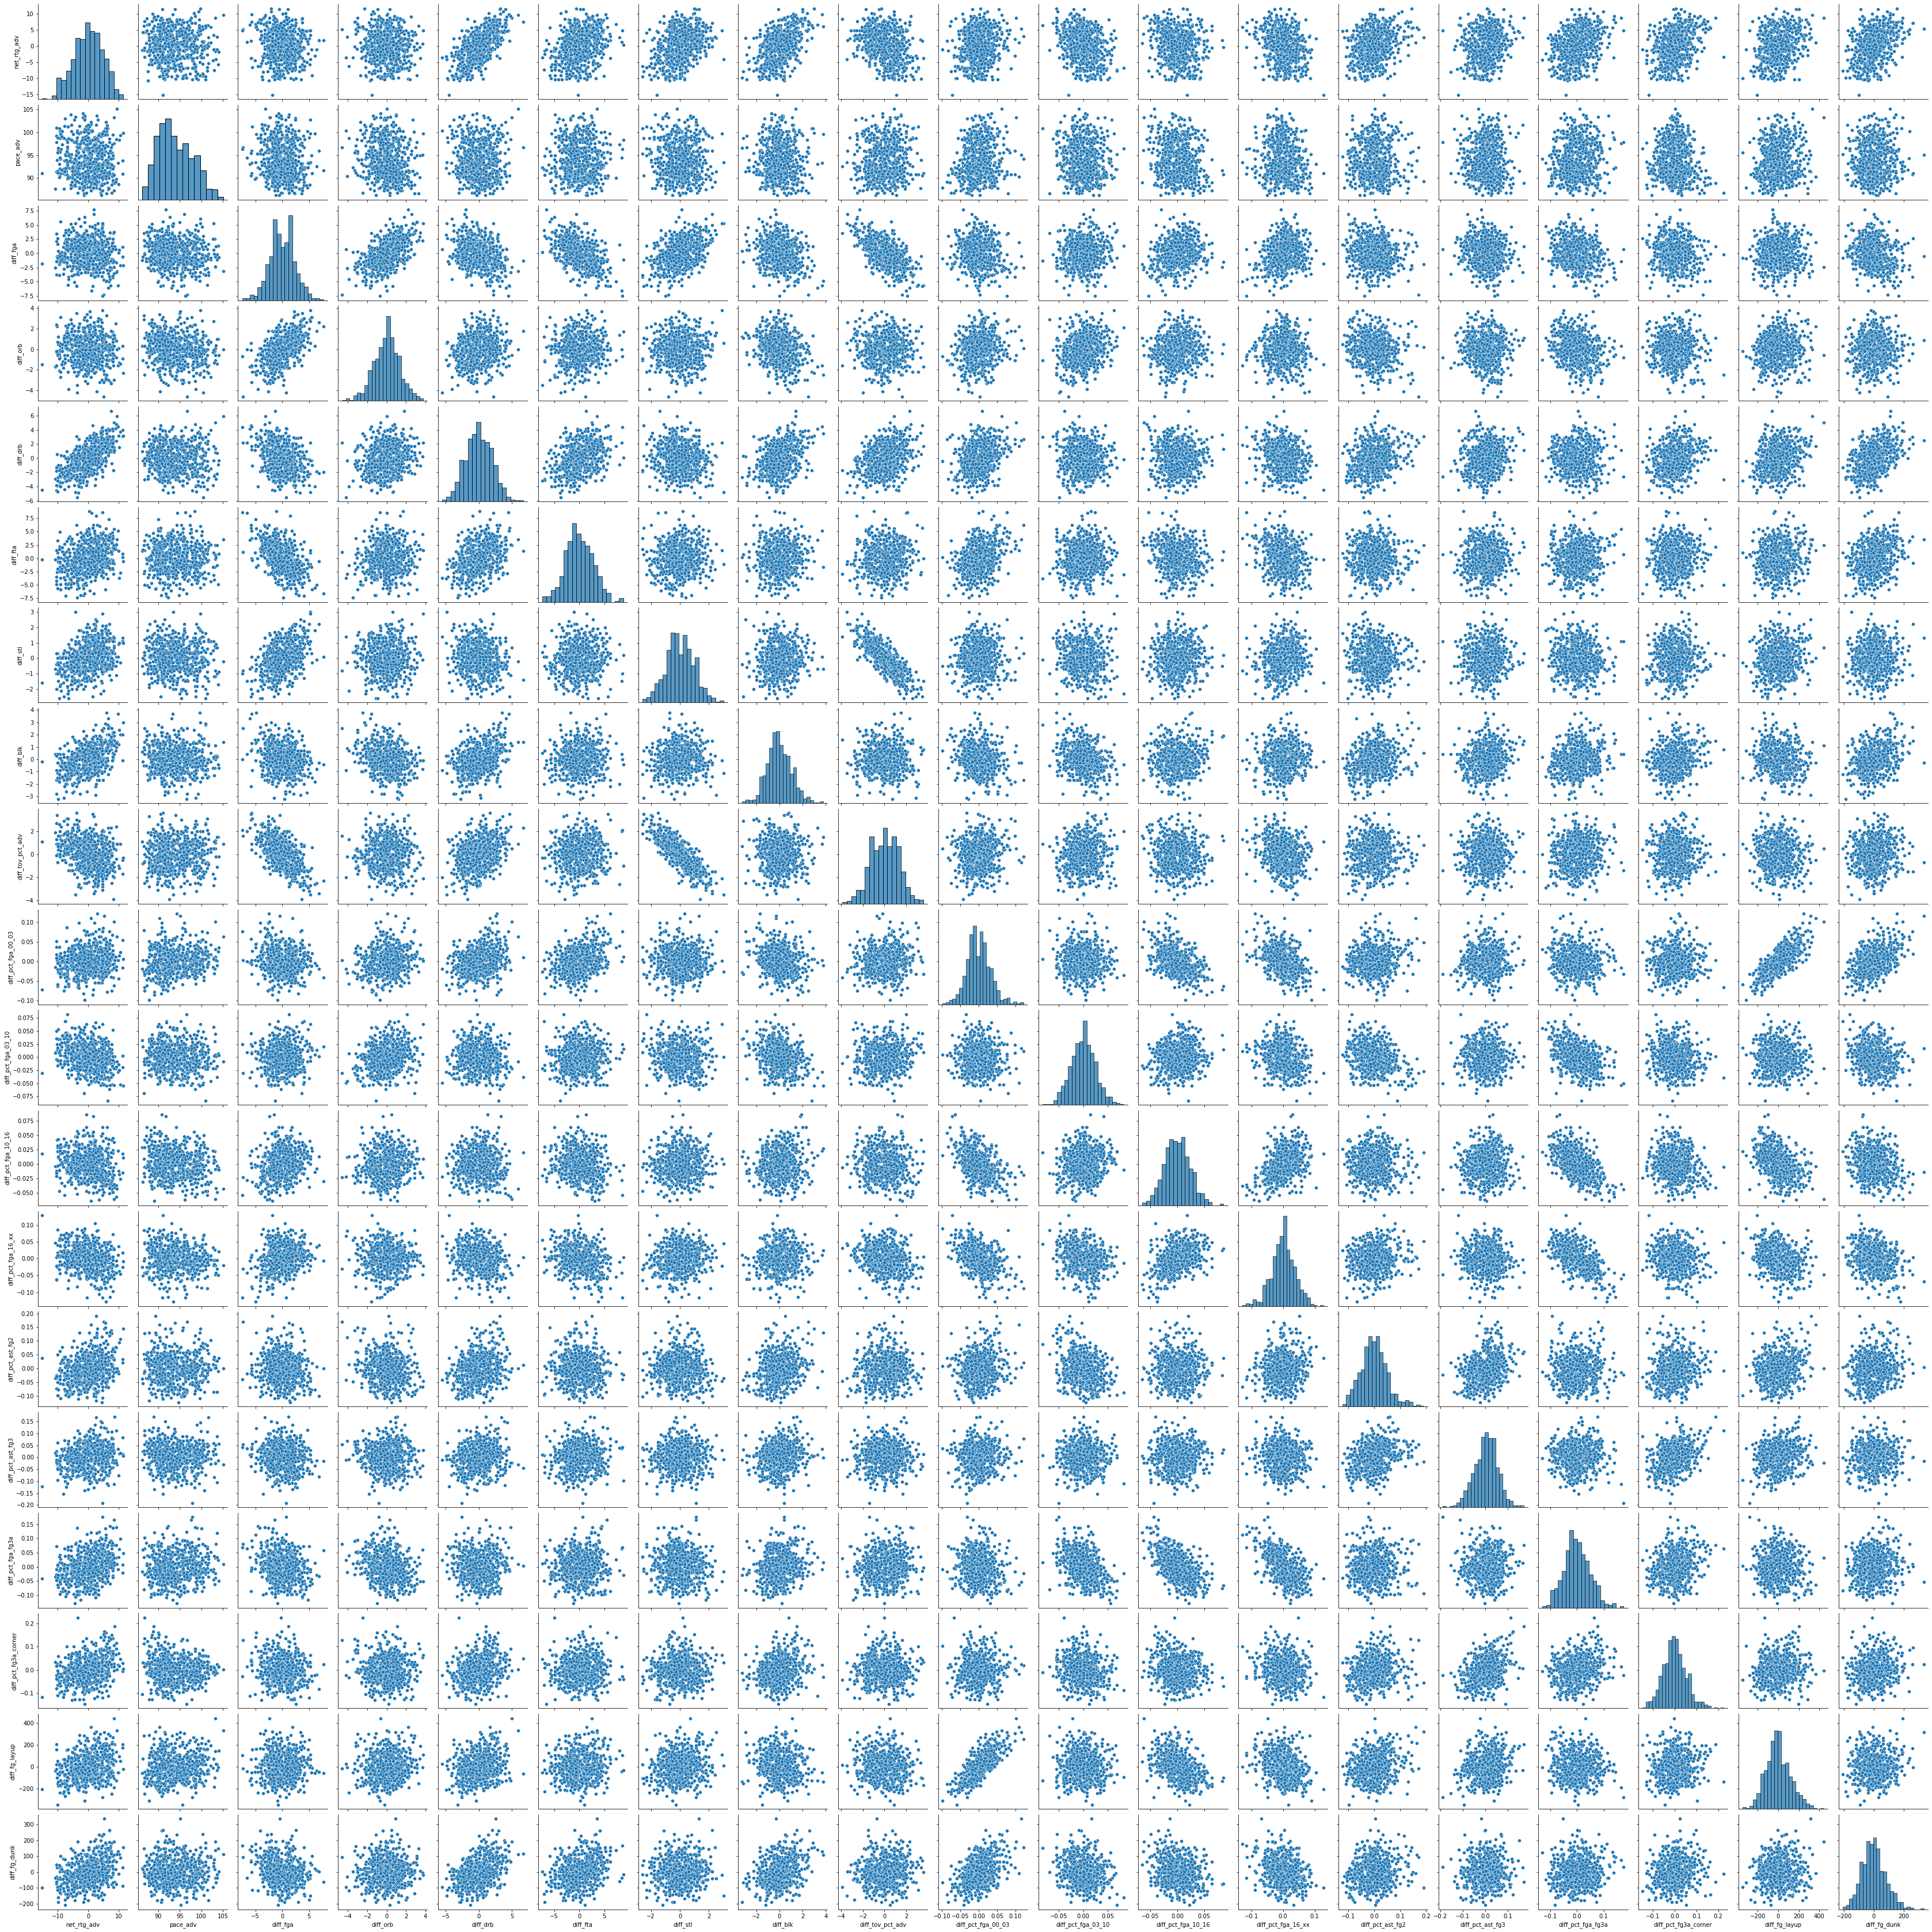

In [214]:
#pairplot
fig=sns.pairplot(combined_df_subset)
#sns.set(font_scale = 3)

#fig.figure.savefig("MVP_pairplot.png")

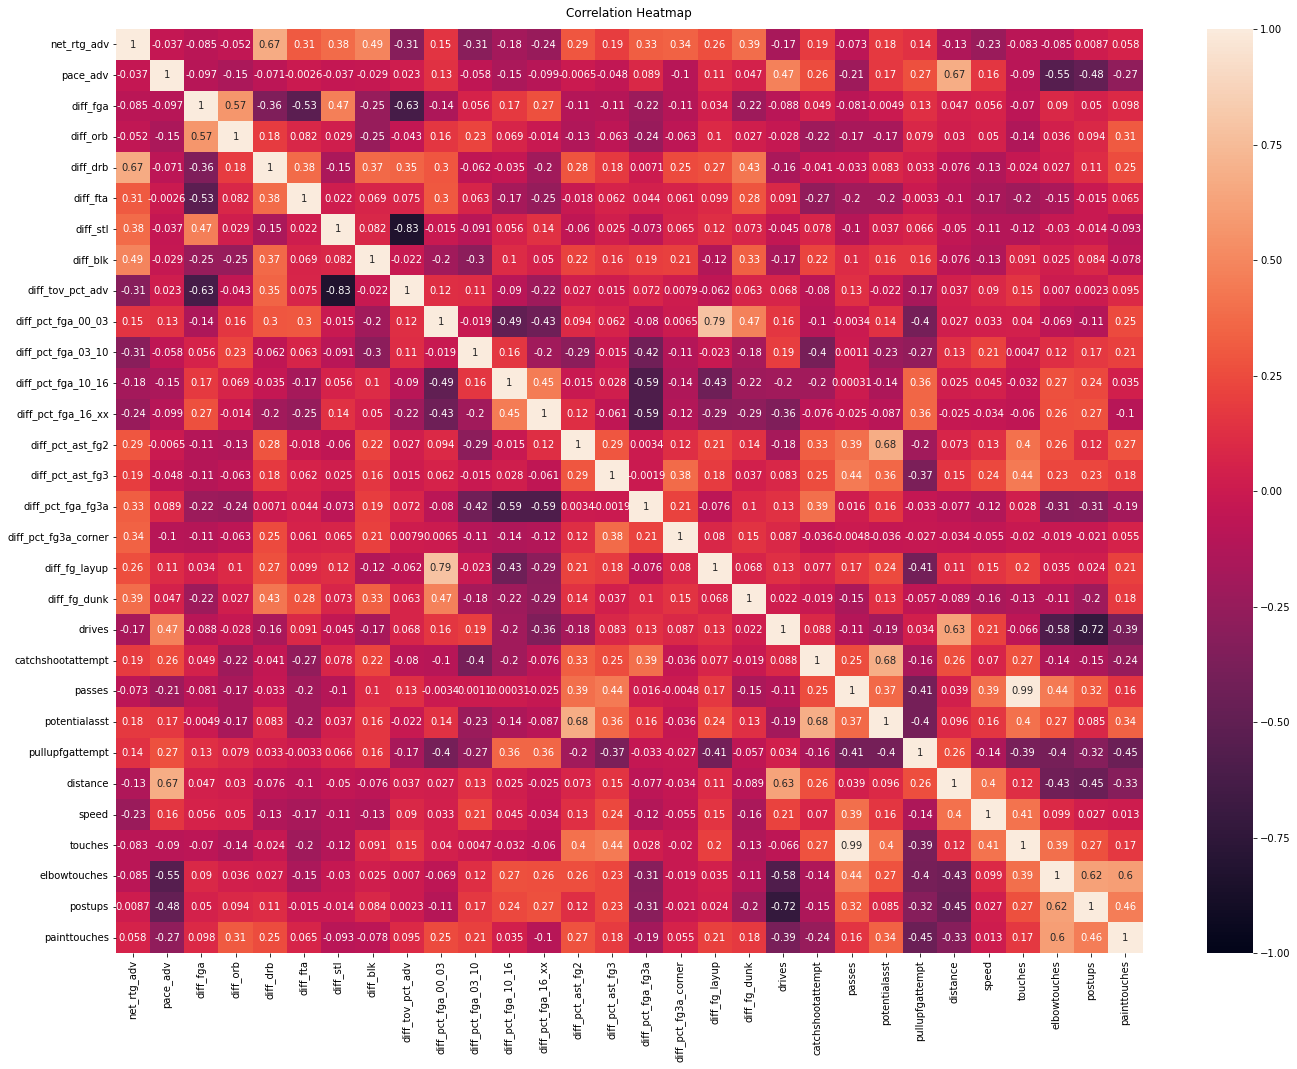

In [373]:
#correlation heatmap
plt.figure(figsize=(23, 17))
heatmap = sns.heatmap(combined_df_subset.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

heatmap.figure.savefig("corr_heatmap.png")

In [577]:
#dropping highly correlated (>0.6) features
#dropping 'diff_fga','diff_stl','diff_fg_layup','diff_pct_fga_10_16','diff_pct_fga_16_xx','diff_tov_pct_adv'

#bball ref features
subset_feature_list=['net_rtg_adv','diff_fta','pace_adv','diff_orb','diff_drb','diff_blk','diff_stl',
                     'diff_pct_fga_00_03','diff_pct_fga_03_10','diff_pct_fga_10_16','diff_pct_fga_16_xx',
                     'diff_pct_ast_fg2','diff_pct_ast_fg3','diff_pct_fga_fg3a','diff_pct_fg3a_corner',
                     'diff_fg_dunk',
#nba.com features                    
'drives','catchshootattempt','passes','potentialasst','pullupfgattempt','distance','speed','touches','elbowtouches','postups','painttouches']

In [578]:
len(subset_feature_list)

27

In [579]:
combined_df_subset = combined_df[subset_feature_list]

In [580]:
#drop na for nba.com + bball ref
combined_df_subset = combined_df_subset.dropna()

# Simple Linear regression and Elastic Net

In [581]:
import random
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE

#### Model on "engineered features" (team_feature-opp_feature)

In [613]:
#split train test
#SPLITTING BY TIME: TRAIN ON OLD, TEST ON NEW
#2021 AND 2022 ARE TEST DATA
x = combined_df_subset.drop(columns = ['net_rtg_adv'])

y = combined_df_subset['net_rtg_adv']

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, shuffle=False) #since data already sorted by year, do not random shuffle, train/test is split by time
                                                    #random_state=40)



In [614]:
#k fold
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

In [615]:
#scale for regularization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)


In [616]:
#suppressing the warnings from regression models
import warnings
warnings.filterwarnings("ignore")

In [617]:
#Elastic Net
alphas = 10 ** np.linspace(-2, 2, 200)
l1_ratio=np.linspace(0, 1, 100)

enet_model = ElasticNetCV(l1_ratio = l1_ratio, 
                          alphas = alphas, 
                          cv=kfold,
                          random_state=42)

enet_model.fit(X_train_scaled, Y_train)

r_squared_train = enet_model.score(X_train_scaled, Y_train)
Adj_r2_train = 1 - (1-r_squared_train) * (len(Y_train)-1)/(len(Y_train)-X_train_scaled.shape[1]-1)

r_squared_test = enet_model.score(X_test_scaled, Y_test)
Adj_r2_test = 1 - (1-r_squared_test) * (len(Y_test)-1)/(len(Y_test)-X_test_scaled.shape[1]-1)

alpha = enet_model.alpha_
l1_ratio = enet_model.l1_ratio_

Y_pred = enet_model.predict(X_test_scaled)

print("r_squared_train: ", round(r_squared_train, 5))
print('Adjusted R2 train:', Adj_r2_train)
print("r_squared_test: ", round(r_squared_test, 5))
print('Adjusted R2 test:', Adj_r2_test)

print('sklearn MAE = ', MAE(Y_test, Y_pred))

print("alpha: ", round(alpha, 3))
print("l1_ratio: ", l1_ratio)

r_squared_train:  0.89312
Adjusted R2 train: 0.8784141559011388
r_squared_test:  0.83017
Adjusted R2 test: 0.6666242907128294
sklearn MAE =  1.5997779167521275
alpha:  0.021
l1_ratio:  0.09090909090909091


In [618]:
enet_model.intercept_

0.09768518518518927

In [619]:
enet_model.coef_

array([ 0.29807006, -0.89466493, -0.75057329,  3.17201735,  0.47517192,
        2.09937218,  0.14518606, -0.33187672, -0.33295878, -0.55649792,
        0.28648613, -0.03273853,  0.57525195,  0.25373377, -0.44860545,
        0.        ,  0.60200106, -0.13337971,  0.12288154,  1.06538408,
        0.18758131,  0.06386517, -0.16838252, -0.34907641,  0.09218439,
        0.52798378])

In [620]:
coef_dict = {}
for coef, feat in zip(enet_model.coef_,subset_feature_list[1:]):
    coef_dict[feat] = coef

In [621]:
subset_feature_list

['net_rtg_adv',
 'diff_fta',
 'pace_adv',
 'diff_orb',
 'diff_drb',
 'diff_blk',
 'diff_stl',
 'diff_pct_fga_00_03',
 'diff_pct_fga_03_10',
 'diff_pct_fga_10_16',
 'diff_pct_fga_16_xx',
 'diff_pct_ast_fg2',
 'diff_pct_ast_fg3',
 'diff_pct_fga_fg3a',
 'diff_pct_fg3a_corner',
 'diff_fg_dunk',
 'drives',
 'catchshootattempt',
 'passes',
 'potentialasst',
 'pullupfgattempt',
 'distance',
 'speed',
 'touches',
 'elbowtouches',
 'postups',
 'painttouches']

In [622]:
coef_dict

{'diff_fta': 0.29807006015590437,
 'pace_adv': -0.8946649262752682,
 'diff_orb': -0.7505732900846825,
 'diff_drb': 3.172017345198381,
 'diff_blk': 0.47517191949653625,
 'diff_stl': 2.0993721782130903,
 'diff_pct_fga_00_03': 0.14518605778444996,
 'diff_pct_fga_03_10': -0.3318767163950761,
 'diff_pct_fga_10_16': -0.3329587751641355,
 'diff_pct_fga_16_xx': -0.5564979237589714,
 'diff_pct_ast_fg2': 0.28648613457650374,
 'diff_pct_ast_fg3': -0.032738531717310296,
 'diff_pct_fga_fg3a': 0.5752519483288588,
 'diff_pct_fg3a_corner': 0.2537337675782024,
 'diff_fg_dunk': -0.4486054497842741,
 'drives': 0.0,
 'catchshootattempt': 0.6020010639169918,
 'passes': -0.13337971167031903,
 'potentialasst': 0.12288153673431997,
 'pullupfgattempt': 1.0653840770028444,
 'distance': 0.18758131403663986,
 'speed': 0.06386517246672402,
 'touches': -0.1683825204616093,
 'elbowtouches': -0.3490764117376808,
 'postups': 0.09218438964719906,
 'painttouches': 0.5279837840997335}

In [623]:
coef_df=pd.DataFrame(coef_dict.items(),columns=['Feature','Coefficient'])

In [624]:
coef_df=coef_df.sort_values('Coefficient',ascending=False)

In [625]:
coef_df

Feature  Coefficient
3               diff_drb     3.172017
5               diff_stl     2.099372
19       pullupfgattempt     1.065384
16     catchshootattempt     0.602001
12     diff_pct_fga_fg3a     0.575252
25          painttouches     0.527984
4               diff_blk     0.475172
0               diff_fta     0.298070
10      diff_pct_ast_fg2     0.286486
13  diff_pct_fg3a_corner     0.253734
20              distance     0.187581
6     diff_pct_fga_00_03     0.145186
18         potentialasst     0.122882
24               postups     0.092184
21                 speed     0.063865
15                drives     0.000000
11      diff_pct_ast_fg3    -0.032739
17                passes    -0.133380
22               touches    -0.168383
7     diff_pct_fga_03_10    -0.331877
8     diff_pct_fga_10_16    -0.332959
23          elbowtouches    -0.349076
14          diff_fg_dunk    -0.448605
9     diff_pct_fga_16_xx    -0.556498
2               diff_orb    -0.750573
1               pace_adv    -0.894665

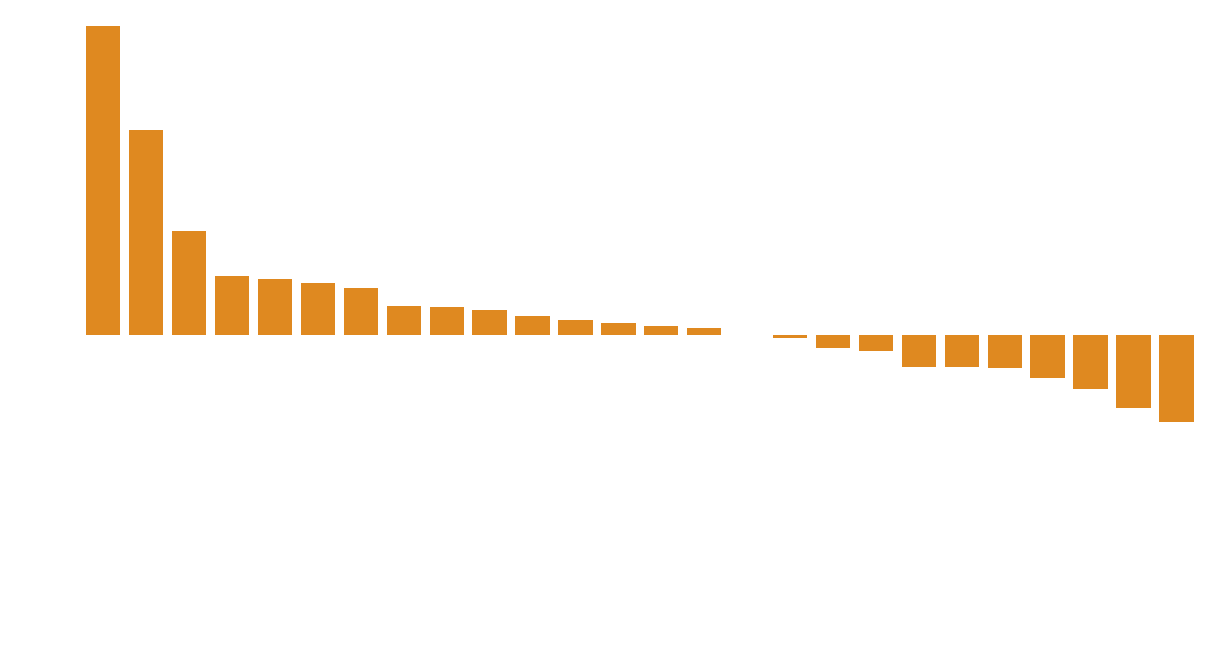

In [626]:
#coefficient plot
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

plt.figure(figsize = (20,8))
sns.set_context("talk")
coplot=sns.barplot(x='Feature',y='Coefficient',data=coef_df, color='darkorange')
plt.xticks(rotation=90)

coplot.figure.savefig("coef_plot_nba_bball_ref.png",transparent=True,
                      bbox_inches="tight"); #avoid cutting off labels

In [630]:
Y_train_pred = enet_model.predict(X_train_scaled)

Text(0.5, 1.0, 'Residuals vs. Predictions')

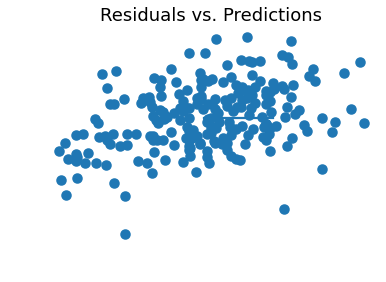

In [635]:
#residual plot using Y_train
lin_reg_residuals = Y_train - Y_train_pred

plt.scatter(Y_train, lin_reg_residuals)
plt.plot([0,5], [0, 0])
plt.title("Residuals vs. Predictions")

<AxesSubplot:xlabel='net_rtg_adv', ylabel='Count'>

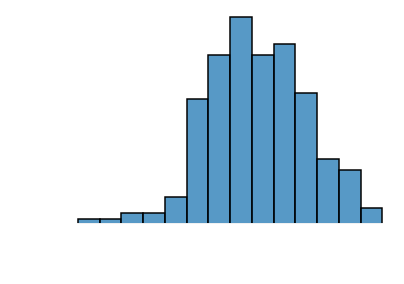

In [636]:
sns.histplot(lin_reg_residuals)

#### re-run model removing zero coef

In [598]:
#re-run model removing zero coef
coef_df_no_zero=coef_df[coef_df.Coefficient!=0]

feature_no_zero=coef_df_no_zero.Feature.tolist()

#split train test
x = combined_df_subset[feature_no_zero]

y = combined_df_subset['net_rtg_adv']

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, shuffle=False) #since data already sorted by year, do not random shuffle, train/test is split by time
                                                    #random_state=40)


In [599]:
#scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [600]:
#Simple Linear Regression

lr_model = LinearRegression()

scores = cross_val_score(lr_model, X_train_scaled, Y_train, cv=kfold)
print(scores)
print("Linear Reg CV Mean Score: ", np.mean(scores))

# Build the Model
lr_model.fit(X_train_scaled, Y_train)


r_squared_train = lr_model.score(X_train_scaled, Y_train)
Adj_r2_train = 1 - (1-r_squared_train) * (len(Y_train)-1)/(len(Y_train)-X_train_scaled.shape[1]-1)

r_squared_test = lr_model.score(X_test_scaled, Y_test)
Adj_r2_test = 1 - (1-r_squared_test) * (len(Y_test)-1)/(len(Y_test)-X_test_scaled.shape[1]-1)


Y_pred = lr_model.predict(X_test_scaled)

print("r_squared_train: ", round(r_squared_train, 5))
print('Adjusted R2 train:', Adj_r2_train)
print("r_squared_test: ", round(r_squared_test, 5))
print('Adjusted R2 test:', Adj_r2_test)

print('sklearn MAE = ', MAE(Y_test, Y_pred))

[0.85005026 0.80793277 0.88314151 0.85583469 0.87377576]
Linear Reg CV Mean Score:  0.8541469979276244
r_squared_train:  0.89422
Adjusted R2 train: 0.8803020433074853
r_squared_test:  0.82043
Adjusted R2 test: 0.6600983651532297
sklearn MAE =  1.6496378563452947


In [601]:
combined_df.iloc[-30:,].loc[:,['team','net_rtg_adv','Year']]

team net_rtg_adv    Year
617       Charlotte Hornets        -0.9  2022.0
618       Memphis Grizzlies         4.8  2022.0
619               Utah Jazz         7.0  2022.0
620            Phoenix Suns         8.2  2022.0
621  Minnesota Timberwolves         1.4  2022.0
622         Milwaukee Bucks         3.4  2022.0
623           Chicago Bulls         2.3  2022.0
624           Atlanta Hawks         0.5  2022.0
625       San Antonio Spurs         0.2  2022.0
626      Los Angeles Lakers        -1.4  2022.0
627           Brooklyn Nets         0.0  2022.0
628   Golden State Warriors         7.0  2022.0
629          Denver Nuggets         2.1  2022.0
630        Sacramento Kings        -5.0  2022.0
631          Indiana Pacers        -2.7  2022.0
632          Boston Celtics         5.5  2022.0
633              Miami Heat         4.6  2022.0
634         Toronto Raptors         1.8  2022.0
635         Houston Rockets        -9.6  2022.0
636  Portland Trail Blazers        -4.0  2022.0
637      Philadelphia 76ers         1.6  2022.0
638      Washington Wizards        -2.8  2022.0
639    Los Angeles Clippers        -0.9  2022.0
640     Cleveland Cavaliers         4.3  2022.0
641        Dallas Mavericks         3.5  2022.0
642    New Orleans Pelicans        -3.3  2022.0
643         New York Knicks        -1.5  2022.0
644           Orlando Magic        -8.7  2022.0
645         Detroit Pistons       -10.1  2022.0
646   Oklahoma City Thunder        -6.8  2022.0

In [602]:
#Laker test
Y_test[-21:-20]

626   -1.4
Name: net_rtg_adv, dtype: object

In [603]:
#Laker pred
Y_pred[-21:-20]

array([-1.23378504])

In [604]:
#Suns test
Y_test[-27:-26]

620    8.2
Name: net_rtg_adv, dtype: object

In [605]:
#Suns pred
Y_pred[-27:-26]

array([7.4514754])

In [606]:
#Knicks test
Y_test[-4:-3]

643   -1.5
Name: net_rtg_adv, dtype: object

In [607]:
#Knicks pred
Y_pred[-4:-3]

array([0.65342571])

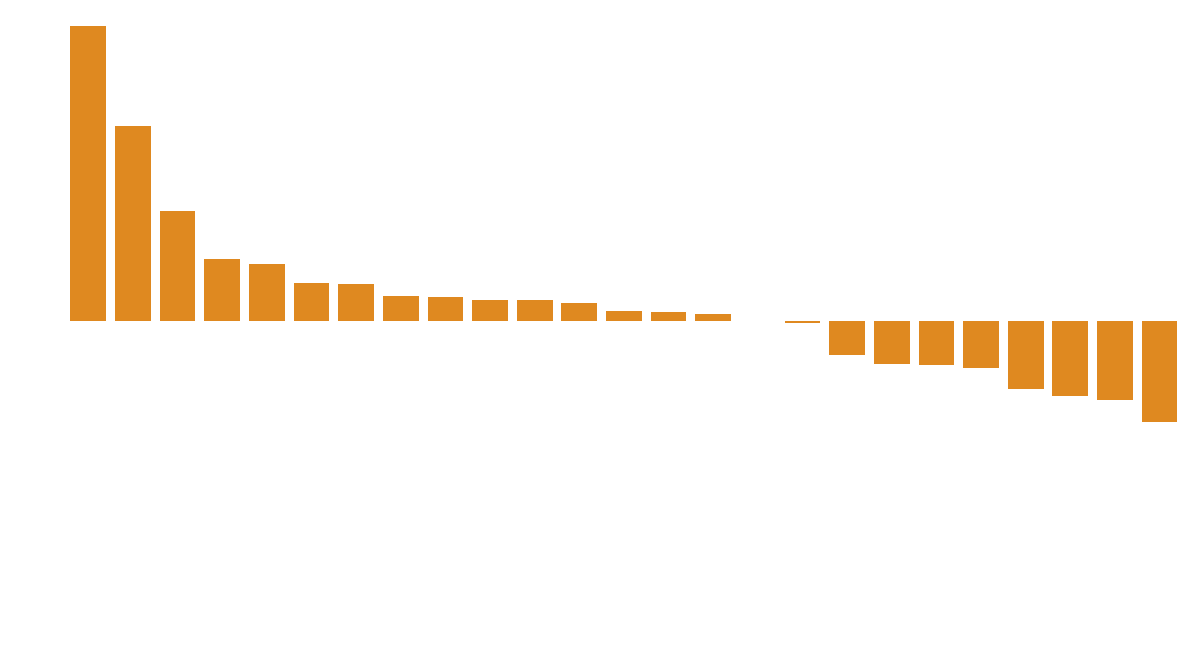

In [611]:
coef_dict = {}
for coef, feat in zip(lr_model.coef_,feature_no_zero):
    coef_dict[feat] = coef
coef_df=pd.DataFrame(coef_dict.items(),columns=['Feature','Coefficient'])
coef_df=coef_df.sort_values('Coefficient',ascending=False)

#coefficient plot
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

plt.figure(figsize = (20,8))
sns.set_context("talk")
coplot=sns.barplot(x='Feature',y='Coefficient',data=coef_df, color='darkorange')
plt.xticks(rotation=90)

coplot.figure.savefig("coef_plot_nba_bball_ref.png",transparent=True,
                      bbox_inches="tight"); #avoid cutting off labels

In [612]:
len(coef_df)

25

## Polynomial and ElasticNet

In [422]:
# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)

# Apply polynomial transformation to test set
X_test_poly = poly.transform(X_test)

scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.fit_transform(X_test_poly)

# Fit a model using polynomial features
alphas = 10 ** np.linspace(-2, 2, 200)
l1_ratio=np.linspace(0, 1, 100)

enet_model = ElasticNetCV(l1_ratio = l1_ratio, 
                          alphas = alphas, 
                          cv=kfold,
                          random_state=42)

enet_model.fit(X_train_poly_scaled, Y_train)

r_squared_train = enet_model.score(X_train_poly_scaled, Y_train)
Adj_r2_train = 1 - (1-r_squared_train) * (len(Y_train)-1)/(len(Y_train)-X_train_poly_scaled.shape[1]-1)

r_squared_test = enet_model.score(X_test_poly_scaled, Y_test)
Adj_r2_test = 1 - (1-r_squared_test) * (len(Y_test)-1)/(len(Y_test)-X_test_poly_scaled.shape[1]-1)

alpha = enet_model.alpha_
l1_ratio = enet_model.l1_ratio_

Y_pred = enet_model.predict(X_test_poly_scaled)

print("r_squared_train: ", round(r_squared_train, 5))
print('Adjusted R2 train:', Adj_r2_train)
print("r_squared_test: ", round(r_squared_test, 5))
print('Adjusted R2 test:', Adj_r2_test)

print('sklearn MAE = ', MAE(Y_test, Y_pred))

print("alpha: ", round(alpha, 3))
print("l1_ratio: ", l1_ratio)


KeyboardInterrupt: 

In [240]:
poly.get_feature_names_out()

array(['1', 'diff_drb', 'diff_stl', 'diff_pct_fga_fg3a',
       'diff_pct_ast_fg2', 'diff_blk', 'diff_pct_fg3a_corner', 'pace_adv',
       'diff_pct_ast_fg3', 'diff_pct_fga_03_10', 'diff_fg_dunk',
       'diff_orb', 'diff_drb^2', 'diff_drb diff_stl',
       'diff_drb diff_pct_fga_fg3a', 'diff_drb diff_pct_ast_fg2',
       'diff_drb diff_blk', 'diff_drb diff_pct_fg3a_corner',
       'diff_drb pace_adv', 'diff_drb diff_pct_ast_fg3',
       'diff_drb diff_pct_fga_03_10', 'diff_drb diff_fg_dunk',
       'diff_drb diff_orb', 'diff_stl^2', 'diff_stl diff_pct_fga_fg3a',
       'diff_stl diff_pct_ast_fg2', 'diff_stl diff_blk',
       'diff_stl diff_pct_fg3a_corner', 'diff_stl pace_adv',
       'diff_stl diff_pct_ast_fg3', 'diff_stl diff_pct_fga_03_10',
       'diff_stl diff_fg_dunk', 'diff_stl diff_orb',
       'diff_pct_fga_fg3a^2', 'diff_pct_fga_fg3a diff_pct_ast_fg2',
       'diff_pct_fga_fg3a diff_blk',
       'diff_pct_fga_fg3a diff_pct_fg3a_corner',
       'diff_pct_fga_fg3a pace_adv', '

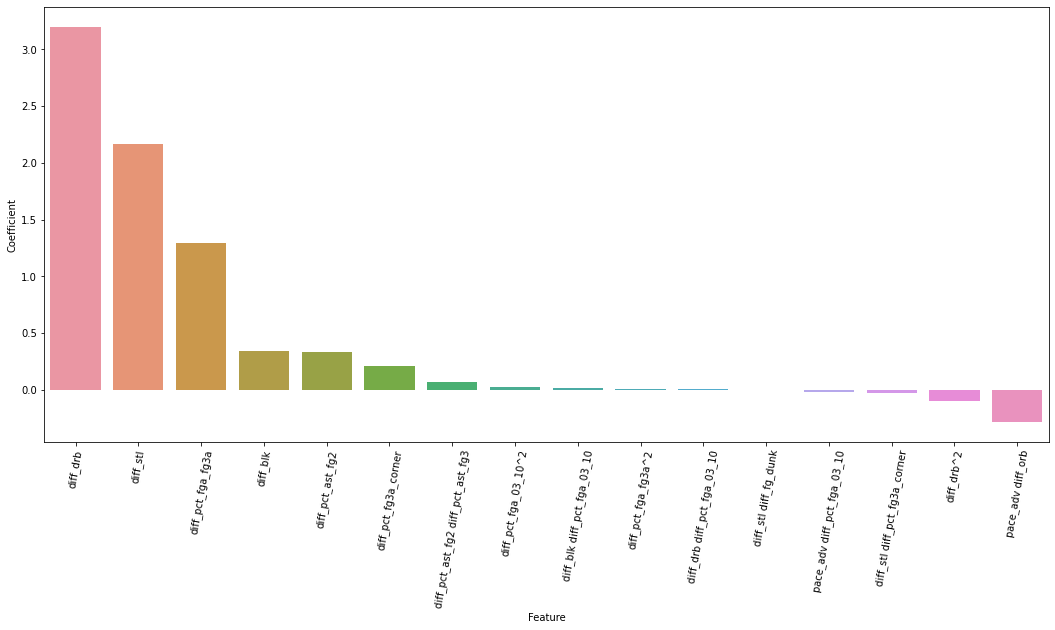

In [241]:
coef_dict = {}
for coef, feat in zip(enet_model.coef_,poly.get_feature_names_out()):
    coef_dict[feat] = coef
coef_df=pd.DataFrame(coef_dict.items(),columns=['Feature','Coefficient'])
coef_df=coef_df.sort_values('Coefficient',ascending=False)
coef_df=coef_df[coef_df.Coefficient!=0]

#coefficient plot
plt.figure(figsize = (18,8))
sns.barplot(x='Feature',y='Coefficient',data=coef_df)
plt.xticks(rotation=80);

In [242]:
X_train_poly_scaled

array([[ 0.        ,  0.29945475,  1.35211815, ...,  1.84331105,
         1.79448099, -0.13669549],
       [ 0.        ,  0.04764738,  0.19738033, ..., -0.61873164,
         0.20981355,  0.77914929],
       [ 0.        ,  0.04764738, -0.32750049, ..., -0.48766169,
         0.5880158 ,  0.38204472],
       ...,
       [ 0.        ,  0.75270802, -0.012572  , ..., -0.48766169,
         0.89057761,  1.58409098],
       [ 0.        ,  1.60885308,  0.93221349, ..., -0.62125222,
        -0.0672196 , -0.64828066],
       [ 0.        , -2.26898043, -1.69219064, ...,  0.29651754,
         1.36333042,  0.15308352]])